In [2]:


import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import os
import random
import numpy as np
 
from tqdm import tqdm
import glob

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, Lambda, concatenate, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split

from PIL import Image

import os
import glob
from tqdm.notebook import tqdm, trange

#initialize GPUs    
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
            



2024-05-08 19:21:49.976057: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 19:21:49.976175: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 19:21:50.112848: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2 Physical GPUs, 1 Logical GPU


# MRI Dataset

In [3]:
config = {
    'IMAGE_WIDTH':256,
    'IMAGE_HEIGHT':256,
    'NUM_CHANNELS':3
}

In [4]:
mask_paths = glob.glob('/kaggle/input/lgg-mri-segmentation/kaggle_3m/*/*_mask.tif')

### categorizing datapoints with empty mask and non empty mask into seperate arrays

In [5]:
empty_masks = []
non_empty_masks = []

for mask_path in tqdm(mask_paths):
    mask = np.array(Image.open(mask_path))
    if (mask == 0).all():
        empty_masks.append(mask_path)
    else:
        non_empty_masks.append(mask_path)

  0%|          | 0/3929 [00:00<?, ?it/s]

### select all datapoints with non empty mask and 200 with empty mask datapoint for train

In [6]:
masks_paths = non_empty_masks + [empty_masks[idx] for idx in np.random.choice(len(empty_masks), 200)]
image_paths = [mask_path.replace('_mask', '') for mask_path in mask_paths]

path_df = pd.DataFrame({'image':image_paths, 'mask':mask_paths})

In [7]:
len(non_empty_masks)

1373

### preparing dataloader

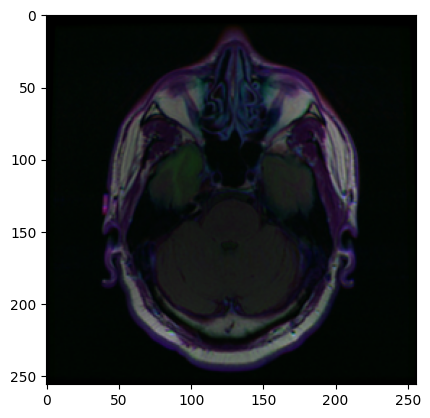

In [8]:
class MRIDataset(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size):
        self.df = df
        self.batch_size = batch_size
        
    def __len__(self):
        return len(self.df) // self.batch_size
    
    def get_image(self, path):
        image = Image.open(path)
        image = np.array(image).astype(np.float32) / 255
        image = resize(image, (config['IMAGE_HEIGHT'], config['IMAGE_WIDTH']), mode='constant', preserve_range=True)        
        return image
    
    def get_mask(self, path):
        mask = Image.open(path)
        mask = np.array(mask).astype(np.bool_)
        mask = resize(mask, (config['IMAGE_HEIGHT'], config['IMAGE_WIDTH']), mode='constant', preserve_range=True)
        mask = mask.astype(np.float32)
        mask = np.expand_dims(mask, axis=-1)

        return mask
    
    def __getitem__(self, idx):
        batch = self.df[idx*self.batch_size:(idx+1)*self.batch_size]
        images = []
        masks = []
        
        for _, (image_path, mask_path) in batch.iterrows():
            images.append(self.get_image(image_path))
            masks.append(self.get_mask(mask_path))
            
        images = np.array(images)
        masks = np.array(masks)
        
        return images, masks
    
dataset = MRIDataset(path_df, 1)
image, mask = dataset[200]
plt.imshow(image[0])
            
    

### train test val split

In [9]:
from sklearn.model_selection import train_test_split

train, test_val = train_test_split(path_df, test_size=0.4)
test, val = train_test_split(test_val, test_size=0.25)
train = MRIDataset(train, 32)
test = MRIDataset(test, 32)
val = MRIDataset(val, 32)

### define loss functions (dice_loss, jaccard_loss) 

In [10]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f*y_pred_f)
    
    dice_coef = (2*intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)
    return dice_coef

def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f*y_pred_f)
    
    jaccard_coef = (intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1)
    return jaccard_coef

def dice_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def jaccard_loss(y_true, y_pred):
    return -jaccard_coef(y_true, y_pred)


# Simple U-Net

In [11]:
def build_model():
    inputs = Input((config['IMAGE_WIDTH'], config['IMAGE_HEIGHT'], config['NUM_CHANNELS']))
    scaled = Lambda(lambda x: x /255)(inputs)
    
    c1 = Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(scaled)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c1)
    c1 = Dropout(0.1)(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c2)
    c2 = Dropout(0.1)(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c3)
    c3 = Dropout(0.2)(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c4)
    c4 = Dropout(0.2)(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    c5 = Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c5)
    
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    c6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c6) 
    
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    c7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c7)     
    
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    c8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c8) 
    
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    c9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c9)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

EPOCHS = 30
lr = 1e-3
# decay_rate = lr/EPOCHS 

model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=[dice_coef])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ lambda[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ dropout_1[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_2[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ dropout_3[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_4[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ dropout_5[0][0] 

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

# Res-U-Net

In [12]:
def build_model():
    inputs = Input((config['IMAGE_WIDTH'], config['IMAGE_HEIGHT'], config['NUM_CHANNELS']))
    scaled = Lambda(lambda x: x /255)(inputs)
    
    c1 = Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(scaled)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c1)
    c1 = Dropout(0.1)(c1)
    res = Conv2D(16, (1,1), padding='same')(scaled)
    c1 = add([c1, res])
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c2)
    c2 = Dropout(0.1)(c2)
    res = Conv2D(32, (1,1), padding='same')(p1)
    c2 = add([c2, res])    
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c3)
    c3 = Dropout(0.2)(c3)
    res = Conv2D(64, (1,1), padding='same')(p2)
    c3 = add([c3, res])    
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c4)
    c4 = Dropout(0.2)(c4)
    res = Conv2D(128, (1,1), padding='same')(p3)
    c4 = add([c4, res])    
    p4 = MaxPooling2D((2, 2))(c4)
    
    c5 = Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c5)
    
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c6)
    u6 = Conv2D(128, (1, 1), padding='same')(u6)
    c6 = add([u6, c6])
    
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c7)     
    u7 = Conv2D(64, (1, 1), padding='same')(u7)
    c7 = add([u7, c7])    
    
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c8) 
    u8 = Conv2D(32, (1, 1), padding='same')(u8)
    c8 = add([u8, c8])
    
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c9)
    u9 = Conv2D(16, (1, 1), padding='same')(u9)
    c9 = add([u9, c9])
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

EPOCHS = 30
lr = 1e-3
# decay_rate = lr/EPOCHS 

res_model = build_model()
res_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=[dice_coef])
res_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 256, 256,  │          0 │ input_layer_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │        448 │ lambda_1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 256, 256,  │          0 │ conv2d_19[0][0]   │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │      2,320 │ dropout_13[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 256, 256,  │          0 │ conv2d_20[0][0]   │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 256, 256,  │         64 │ lambda_1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 256,  │          0 │ dropout_14[0][0], │
│                     │ 16)               │            │ conv2d_21[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ add[0][0]         │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 128, 128,  │          0 │ conv2d_22[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 128, 128,  │      9,248 │ dropout_15[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 128, 128,  │          0 │ conv2d_23[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 128, 128,  │        544 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128, 128,  │          0 │ dropout_16[0][0], │
│                     │ 32)               │            │ conv2d_24[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ add_1[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_5[

 Total params: 1,995,905 (7.61 MB)

 Trainable params: 1,995,905 (7.61 MB)

 Non-trainable params: 0 (0.00 B)

# Training

### training UNet

In [13]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_mri.keras', verbose=1, save_best_only=True)

callbacks = [
#         tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        checkpointer]

results = model.fit(train, validation_data=val, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1715196221.672172      85 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 807ms/step - dice_coef: 0.0105 - loss: 0.2416
Epoch 1: val_loss improved from inf to 0.08561, saving model to model_for_mri.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 146s 974ms/step - dice_coef: 0.0105 - loss: 0.2399 - val_dice_coef: 0.0367 - val_loss: 0.0856
Epoch 2/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - dice_coef: 0.0326 - loss: 0.0482
Epoch 2: val_loss improved from 0.08561 to 0.06796, saving model to model_for_mri.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 63s 795ms/step - dice_coef: 0.0326 - loss: 0.0482 - val_dice_coef: 0.0458 - val_loss: 0.0680
Epoch 3/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - dice_coef: 0.0515 - loss: 0.0460
Epoch 3: val_loss improved from 0.06796 to 0.04455, saving model to model_for_mri.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 64s 801ms/step - dice_coef: 0.0516 - loss: 0.0460 - val_dice_coef: 0.0678 - val_loss: 0.0446
Epoch 4/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - dice_coef: 0.0847 - loss: 0.0405
Epoch 4: val_loss improved from 0.04455 to

### train res-U-Net

In [14]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('res_model_for_mri.keras', verbose=1, save_best_only=True)

callbacks = [
#         tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        checkpointer]

results = res_model.fit(train, validation_data=val, epochs=EPOCHS, callbacks=callbacks)


Epoch 1/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - dice_coef: 0.0100 - loss: 0.1961
Epoch 1: val_loss improved from inf to 0.07261, saving model to res_model_for_mri.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 102s 812ms/step - dice_coef: 0.0101 - loss: 0.1947 - val_dice_coef: 0.0307 - val_loss: 0.0726
Epoch 2/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - dice_coef: 0.0345 - loss: 0.0492
Epoch 2: val_loss improved from 0.07261 to 0.05468, saving model to res_model_for_mri.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 63s 792ms/step - dice_coef: 0.0346 - loss: 0.0491 - val_dice_coef: 0.0577 - val_loss: 0.0547
Epoch 3/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - dice_coef: 0.0643 - loss: 0.0419
Epoch 3: val_loss improved from 0.05468 to 0.03636, saving model to res_model_for_mri.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 63s 796ms/step - dice_coef: 0.0644 - loss: 0.0419 - val_dice_coef: 0.0842 - val_loss: 0.0364
Epoch 4/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - dice_coef: 0.0817 - loss: 0.0403
Epoch 4: val_loss d

# Plotting predictions

### predicting for 10 selected test images from UNet

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


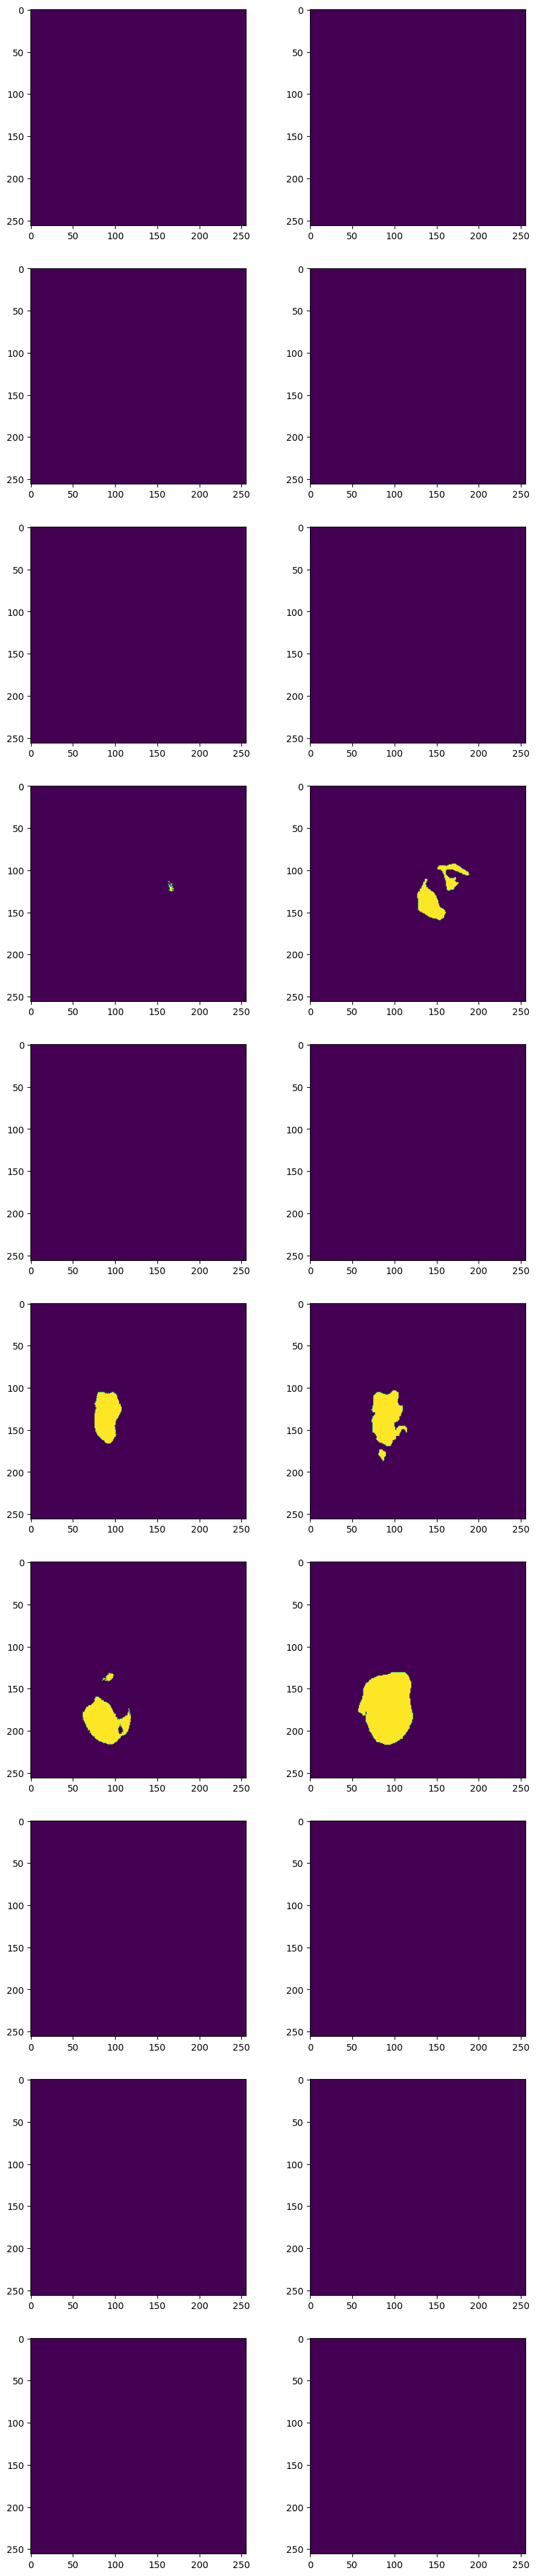

In [15]:
model.load_weights('/kaggle/working/model_for_mri.keras')

i = 10
image, mask = test[i]
pred = res_model.predict(image)

plt.subplots(10, 2, figsize=(10, 50))
for i in range(10):
    plt.subplot(10, 2, i*2+1)
    plt.imshow(pred[i] > .5)
    plt.subplot(10, 2, i*2+2)
    plt.imshow(mask[i])
plt.show()

### predicting for 10 selected test images from res-UNet

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


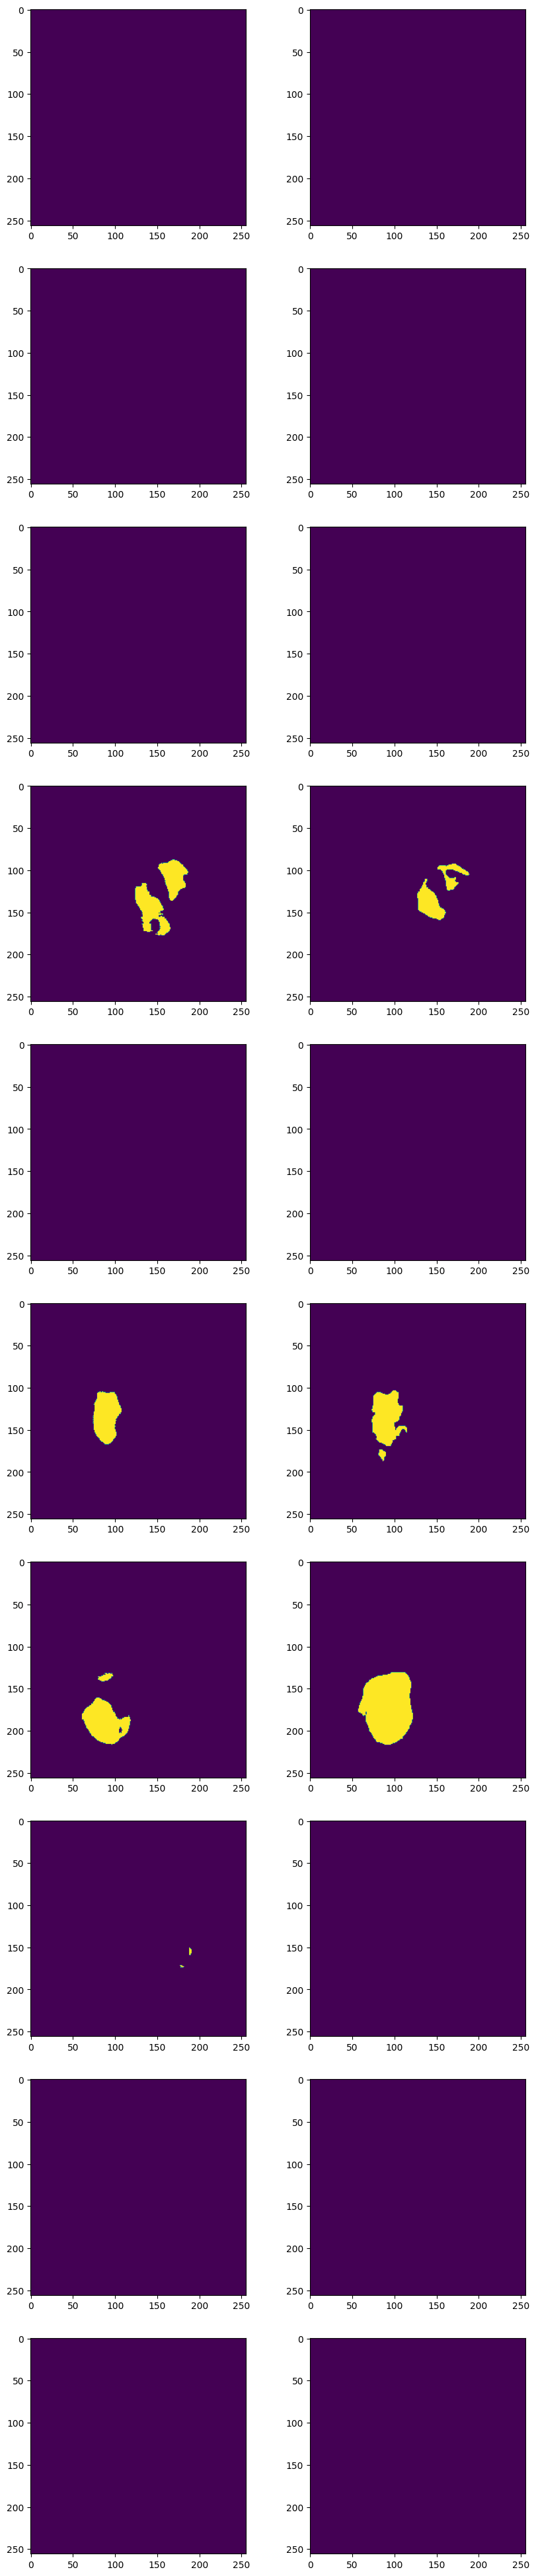

In [16]:
res_model.load_weights('/kaggle/working/res_model_for_mri.keras')

i = 10
image, mask = test[i]
pred = res_model.predict(image)

plt.subplots(10, 2, figsize=(10, 50))
for i in range(10):
    plt.subplot(10, 2, i*2+1)
    plt.imshow(pred[i] > .5)
    plt.subplot(10, 2, i*2+2)
    plt.imshow(mask[i])
plt.show()